In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import matplotlib.pyplot as plt
from glob import glob
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from timeit import default_timer as timer

In [2]:
from glob import glob
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]
#sc = MinMaxScaler()

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
#         full_data = np.concatenate((inputs, outputs), axis=1)
#         full_data = full_data.reshape((-1,110))
#         full_data = sc.fit_transform(full_data)
#         full_data = full_data.reshape((-1,110,2))
#         full_data = np.split(full_data, [50,110], axis=1)
        
        inputs = Variable(torch.tensor(inputs, dtype=torch.float32))
        outputs = Variable(torch.tensor(outputs, dtype=torch.float32))
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
        
#         full_data = np.concatenate((inputs, outputs), axis=1)
#         full_data = full_data.reshape((-1,110))
#         full_data = sc.fit_transform(full_data)
#         full_data = full_data.reshape((-1,110,2))
#         full_data = np.split(full_data, [50,110], axis=1)
        
        inputs = Variable(torch.tensor(inputs, dtype=torch.float32))
        outputs = Variable(torch.tensor(outputs, dtype=torch.float32))
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        
#         full_data = np.concatenate((inputs, outputs), axis=1)
#         full_data = full_data.reshape((-1,110))
#         full_data = sc.fit_transform(full_data)
#         full_data = full_data.reshape((-1,110,2))
#         full_data = np.split(full_data, [50,110], axis=1)
        
        inputs = Variable(torch.tensor(inputs, dtype=torch.float32))
        outputs = Variable(torch.tensor(outputs, dtype=torch.float32))

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

In [3]:
train_dataset = ArgoverseDataset(city = city, split= 'train')
val_dataset = ArgoverseDataset(city = city, split = 'val')

In [4]:
batch_sz = 50  # batch size 
val_loader = DataLoader(val_dataset,batch_size=batch_sz)
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [5]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.hidden2label = nn.Sequential(
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.ReLU(True),
            nn.Linear(int(hidden_size/2), int(hidden_size/2)),
            nn.ReLU(True),
            nn.Linear(int(hidden_size/2), int(hidden_size/2)),
            nn.ReLU(True),
            nn.Linear(int(hidden_size/2), num_classes),
        )
        
    def forward(self, x):  
        
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        y  = self.hidden2label(h_out)
        
        return y.reshape(-1, 120)

In [ ]:
seq_length = 100
num_epochs = 25
learning_rate = 0.0001

input_size = 1
hidden_size = 200
num_layers = 1

num_classes = 120

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    total_loss = 0
    start = timer()
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        inp = inp.reshape(-1, 100, 1)
        out = out.reshape(-1, 120)
        output = lstm(inp)
        optimizer.zero_grad()
        loss = criterion(output, out)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    end = timer()
    time = end - start
    print('epoch {} loss: {} time: {}'.format(epoch, total_loss / len(train_dataset), time))

epoch 0 loss: 48.32448263130562 time: 141.94755885750055
epoch 1 loss: 38.44589919837187 time: 138.40246231202036
epoch 2 loss: 62.760767138498835 time: 142.60437182430178
epoch 3 loss: 46.50306009177692 time: 142.19242187775671
epoch 4 loss: 39.04497122988245 time: 142.01596861798316
epoch 5 loss: 36.80801884005262 time: 140.11467927135527
epoch 6 loss: 36.56920723818679 time: 141.69602067768574
epoch 7 loss: 60.7427567288556 time: 141.12100706342608


In [ ]:
torch.save(lstm.state_dict(), "lstm2.pth")

In [8]:
def create_random_plot():
    for i_batch, sample_batch in enumerate(train_loader):
        rand = np.random.randint(batch_sz, size=1)
        inp, out = sample_batch
        inp_edit = inp.reshape(-1, 100, 1)
        preds = lstm(inp_edit)
        preds = preds.detach().numpy().reshape(50,60,2)
        plt.scatter(x=inp[rand,:,0],y=inp[rand,:,1], color="red", alpha=0.5, label="Input Points")
        plt.scatter(x=out[rand,:,0],y=out[rand,:,1], color="blue", alpha=0.5, label="Ground Truth")
        plt.scatter(x=preds[rand,:,0],y=preds[rand,:,1], color="green", alpha=0.5, label="Predictions")
        plt.legend()
        plt.show()
        break

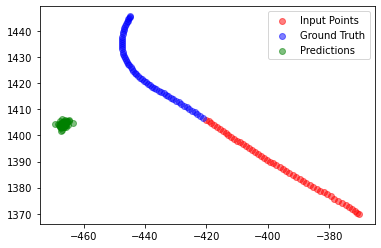

In [13]:
create_random_plot()